In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import Image
#check version pandas

# Seaborn is a cool library to use whenever starting data exploration
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=14)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Data exploration
## Table Of Content:

* [**Clustering methods**](#fifth-bullet)
    * [K-means](#Kmeans-bullet)
    * [Hierarchichal clustering](#HC-bullet)
    * [DBSCAN](#DBSCAN-bullet)
       
* [**Appendix**](#appendix-bullet)
    * [Gaussian mixtures](#gm-bullet)
    
* [**Exo**](#exo-bullet)

# Loading the data 


In [90]:
from sklearn.preprocessing import StandardScaler

df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],"na")
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = "ne"
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = "po"

df_im.loc[response=="po",'Mutant peptide'] = df_im.loc[response=="po",'Mutant peptide']+"*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]]

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im = X_im.rename(columns = d, inplace = False) # rename the columns
# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im['RNA_expr'] = np.log10(X_im['RNA_expr'])
X_im['WT_affin'] = np.log10(X_im['WT_affin'])
X_im['MUT_affin'] = np.log10(X_im['MUT_affin'])

# select the numerical features

X_im = X_im.set_index(df_im['Mutant peptide'], inplace=False)

X_im_num = X_im.copy()
X_im['Response'] = response
X_im.reset_index()



#scaling 
scaler = StandardScaler()
X_im_scaled = scaler.fit_transform(X_im_num)


# Clustering <a class="anchor" id="fifth-bullet"></a>


Clustering is an unsupervised method that serves many puposes:

<ol>
<li>Pattern detection: discover hidden patterns in your data</li>
<li>Compression: replace all cluster members by one representive</li>
<li>Data augmentation: replace noisy feature vectors by the cluster consensus vector</li>
<li>Dimensionality reduction: replace a feature vector by cluster similarities</li>
<li>Outlier detection: detect feature vectors far away from cluster centers</li>
<li>Semisupervised learning: assign cluster labels to unlabeled cluster members</li>
<li>...</li>
</ol>

If you find some cluster-like structures in your data and if they correspond to one of your hypothesis then you already came a long way. Rarely you can get there in one step, but you need to carefully clean and normalize your data to discover these structures. Be aware that clustering algorithms are not magical techniques that give you a straight answer: you will need to find good hyperparameters for the model to work, and your expertise and understanding of the data is crutial to obtain good results.

## K-means clustering <a class="anchor" id="Kmeans-bullet"></a>

The [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm is a widely used clustering algorithm. The K-means algorithm aims at finding the right partition of the data ($\pmb{X_1},...,\pmb{X_n}$) into $K$ clusters $\pmb{C}={C_1,...,C_K}$ so that the within cluster sum of squares (inertia) is minimized:

$\pmb{C}=argmin_{\pmb{C}} \sum_{k=1}^{K}\sum_{i \in C_k}||\pmb{X_i}-\pmb{\mu_k}||^2$

$\pmb{\mu_k}=\frac{1}{|C_k|}\sum_{i \in C_k}\pmb{X_i}$

K-means requires the number of clusters as input. The greedy algorithm consists of 3 main parts:
<ol>
<li>Choose $K$ points from $\pmb{X_i}$ as initial values for $\pmb{\mu_k}$. These initial points should be spread out over the dataset</li>
<li>Assignment step: assign each $\pmb{X_i}$ to a cluster $C_k=argmin_{C_k} ||\pmb{X_i}-\pmb{\mu_k}||^2$ </li>
<li>Update step: recalculate $\pmb{\mu_k}=\frac{1}{|C_k|}\sum_{i \in C_k}\pmb{X_i}$</li>
<li>Iterate steps 2 & 3 until convergence</li>
</ol>

![km1](../images/Kmeans1.png)
![km2](../images/Kmeans2.png)

For data with a cluster structure K-means complexity is often linear in the number of datapoints $\pmb{X_i}$ and it requires little additional memory. The data can be split into different chunks and the algo still works. Faster versions of the basic algorithm are available, e.g. [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans). This makes it an attractive algorithm for very large datasets.

K-means is a greedy algorithm, i.e. it will only find a local minimum of the inertia. Therefore it is good practice to run the algorithms several times with different initialization (random_state set to different values).

In [91]:
from sklearn import cluster
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(X_im_scaled)

kmeans_3 = cluster.KMeans(3)#create a K means clustering object that will have 3 clusters
kmeans_3.fit(x_pca)

kmeans_7 = cluster.KMeans(7)#create a K means clustering object that will have 7 clusters
kmeans_7.fit(x_pca)

## .labels_ contains the resulting cluster affiliation for each point
kmeans_7.labels_

array([6, 1, 4, ..., 3, 4, 3], dtype=int32)

**Question:** why do I use the results of the PCA here ?

/home/wandrille/Installed_software/anaconda3/envs/introML2022/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


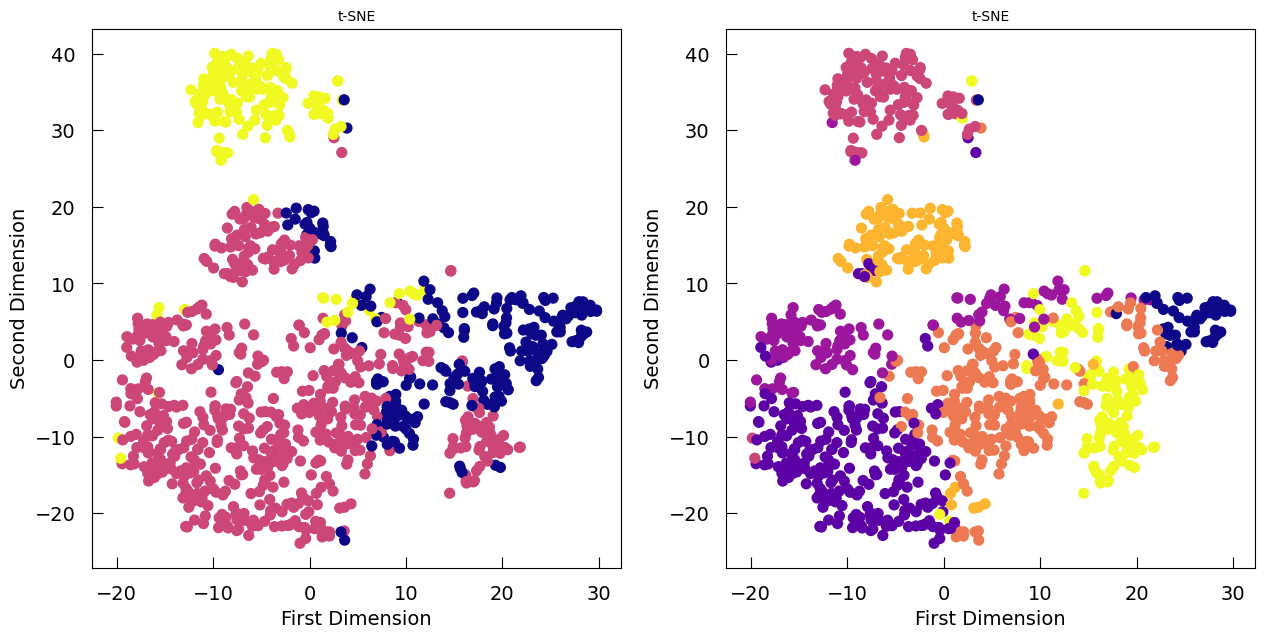

In [92]:
# now we want to represent the results of this clustering
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,perplexity=50, init='pca', learning_rate='auto').fit(x_pca)
X_im_embedded = tsne.embedding_ 

plt.subplots(figsize=(15,7))

plt.subplot(1,2,1)
plt.scatter(X_im_embedded[:,0],X_im_embedded[:,1],c=kmeans_3.labels_,s=50,cmap='plasma')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE',fontsize=10)

plt.subplot(1,2,2)
plt.scatter(X_im_embedded[:,0],X_im_embedded[:,1],c=kmeans_7.labels_,s=50,cmap='plasma')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE',fontsize=10)

plt.show()

We see that the number of clusters defines the k-means clustering outcome. It is difficult to say by looking at the t-SNE projections, whether 3 or 7 clusters better reveal underlying patterns. Another way to find the 'optimal' number of clusters is to use any of the clustering quality metrics provided by [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Here we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) metric: 

The **silhouette score** is **calculated for each point** using 

* the mean intra-cluster distance : $a$
* the distance between a sample and the nearest cluster that the sample is not a part of : $b$


The Silhouette score for a single point is $SC=\frac{(b-a)}{max(a,b)}$

The sklearn function `silhouette_score` (from `sklearn.metrics`) returns the mean Silhouette score over all samples for a given clustering result. To obtain the values for each sample, use `silhouette_samples`.

$SC$ is always between -1 (bad clustering) and 1 (perfect clustering).

![silhouette illustration](../images/silhouette.png)

So the **silhouette score should be maximized.**

> Warning : some score should be maximized and some other minimized. Be sure you know which one it should be before interpreting your results!



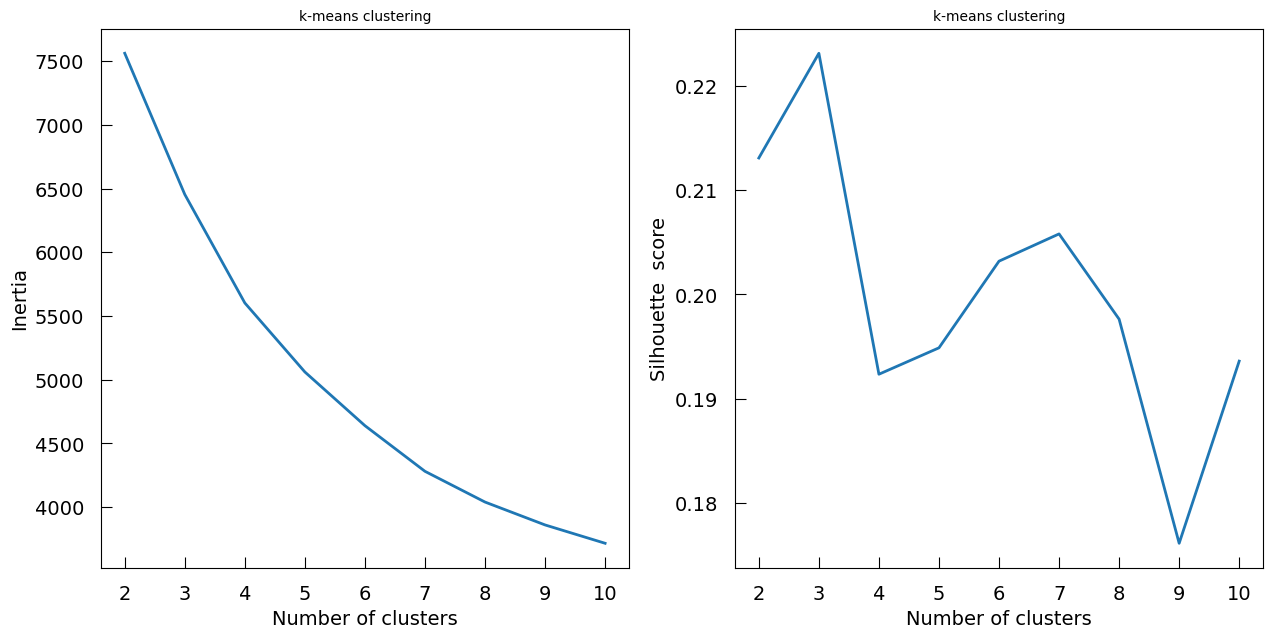

In [93]:
from sklearn import cluster
from sklearn.metrics import silhouette_score

nr_clusters = np.arange(2,11)

inertias = []
silhouettes = []
for n in nr_clusters:
    kmeans = cluster.KMeans(n)
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(x_pca,kmeans.labels_))

plt.subplots(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(nr_clusters, inertias, ls="-", lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('k-means clustering',fontsize=10)

plt.subplot(1,2,2)
plt.plot(nr_clusters, silhouettes, ls="-", lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette  score')
plt.title('k-means clustering',fontsize=10)


plt.show()

The plot to the left gives us the inertia as a function of the number of clusters (remember the inertia is the sum of squares, the score k-means is trying to minimize). The inertia decreases as the number of clusters increases (which is expected) and does not give us much information about the best cluster count to use. The silhouette score is more informative (left plot). 

Here, we see that $SC$ proposes $K=3$ and has a second local maximum at $K=7$ (see above).

### Micro-exercise: Kmeans

Perform a kmean clustering on the AML data. What is the best number of clusters ? Does it looks like it correlates with the auc metric ?


In [94]:
df_aml=pd.read_excel('../data/gene_drug_sens.xlsx')
X_aml=df_aml[df_aml.columns[9:]] 

# df_aml.auc <-- this is the target metric

X_aml.head()

,CD86,FAM49A,ERMN,CHD5,RP11-333E13.2,KLHDC3,HNMT,ADAP2,B3GNT2,RP11-196G18.24,TLR2,MIR223,RAB43P1,GYPC,HSD17B13,HNRNPA1,NAPSB
0,-1.120073,-0.148654,-1.579624,-0.756073,0.471452,1.068268,-0.157964,-1.001751,1.556003,-1.608982,0.751515,0.987769,0.232332,0.981147,-2.021119,-1.185687,-0.710025
1,2.498957,-1.015880,-0.859471,-0.555560,-0.142550,-0.161521,2.279642,-0.933841,-0.189892,0.313041,2.097701,-1.627445,-0.961402,-0.523684,0.255906,0.885343,0.900553
2,0.176687,-0.490400,-0.611194,-0.443875,0.876031,-0.147330,0.112438,-0.185127,0.235198,-1.389968,0.007096,1.291810,-0.504791,0.813038,-0.741312,-1.180863,-2.541507
3,0.918236,0.377131,-0.410336,-0.033461,-0.014791,1.218267,1.122505,-0.333728,0.038227,-0.187054,-0.376509,0.826023,0.847269,-0.466044,0.374157,0.585562,-0.747859
4,-1.004299,-0.826399,0.995739,-1.426430,-0.053345,0.585897,-0.876732,0.564804,-0.835560,-0.566891,0.546441,-0.371254,1.609191,0.220240,-2.180800,1.076900,0.411095


## Hierarchical clustering <a class="anchor" id="HC-bullet"></a>

Hierarchical clustering is an algorithms that iteratively merges data points or groups of data points. It starts with $N$ clusters, one cluster per data point. It first calculates the pairwise distances between all clusters. It then selects the two closests clusters and merges them into a new cluster. Next it recalculates the distances between the newly formed cluster and the remaining clusters. It repeats these steps until a specified number of clusters is reached or until all distances between clusters are larger than a specified threshold.

![HC](../images/Hierachi.png)

Since this type of algorithm requires pairwise distance calculations and does this up to $N$ times until all clusters are merged, the complexity of the algorithms is $N^3$. This is often too slow for large datasets. The algorithms can be accelarated by speeding up disnace calculations or initialize the clusters with a coarse k-means clustering.

The main advantage of the algorithm is the visualization of the results as dendograms and the easy interpretability of the results.

<Figure size 2000x3000 with 0 Axes>

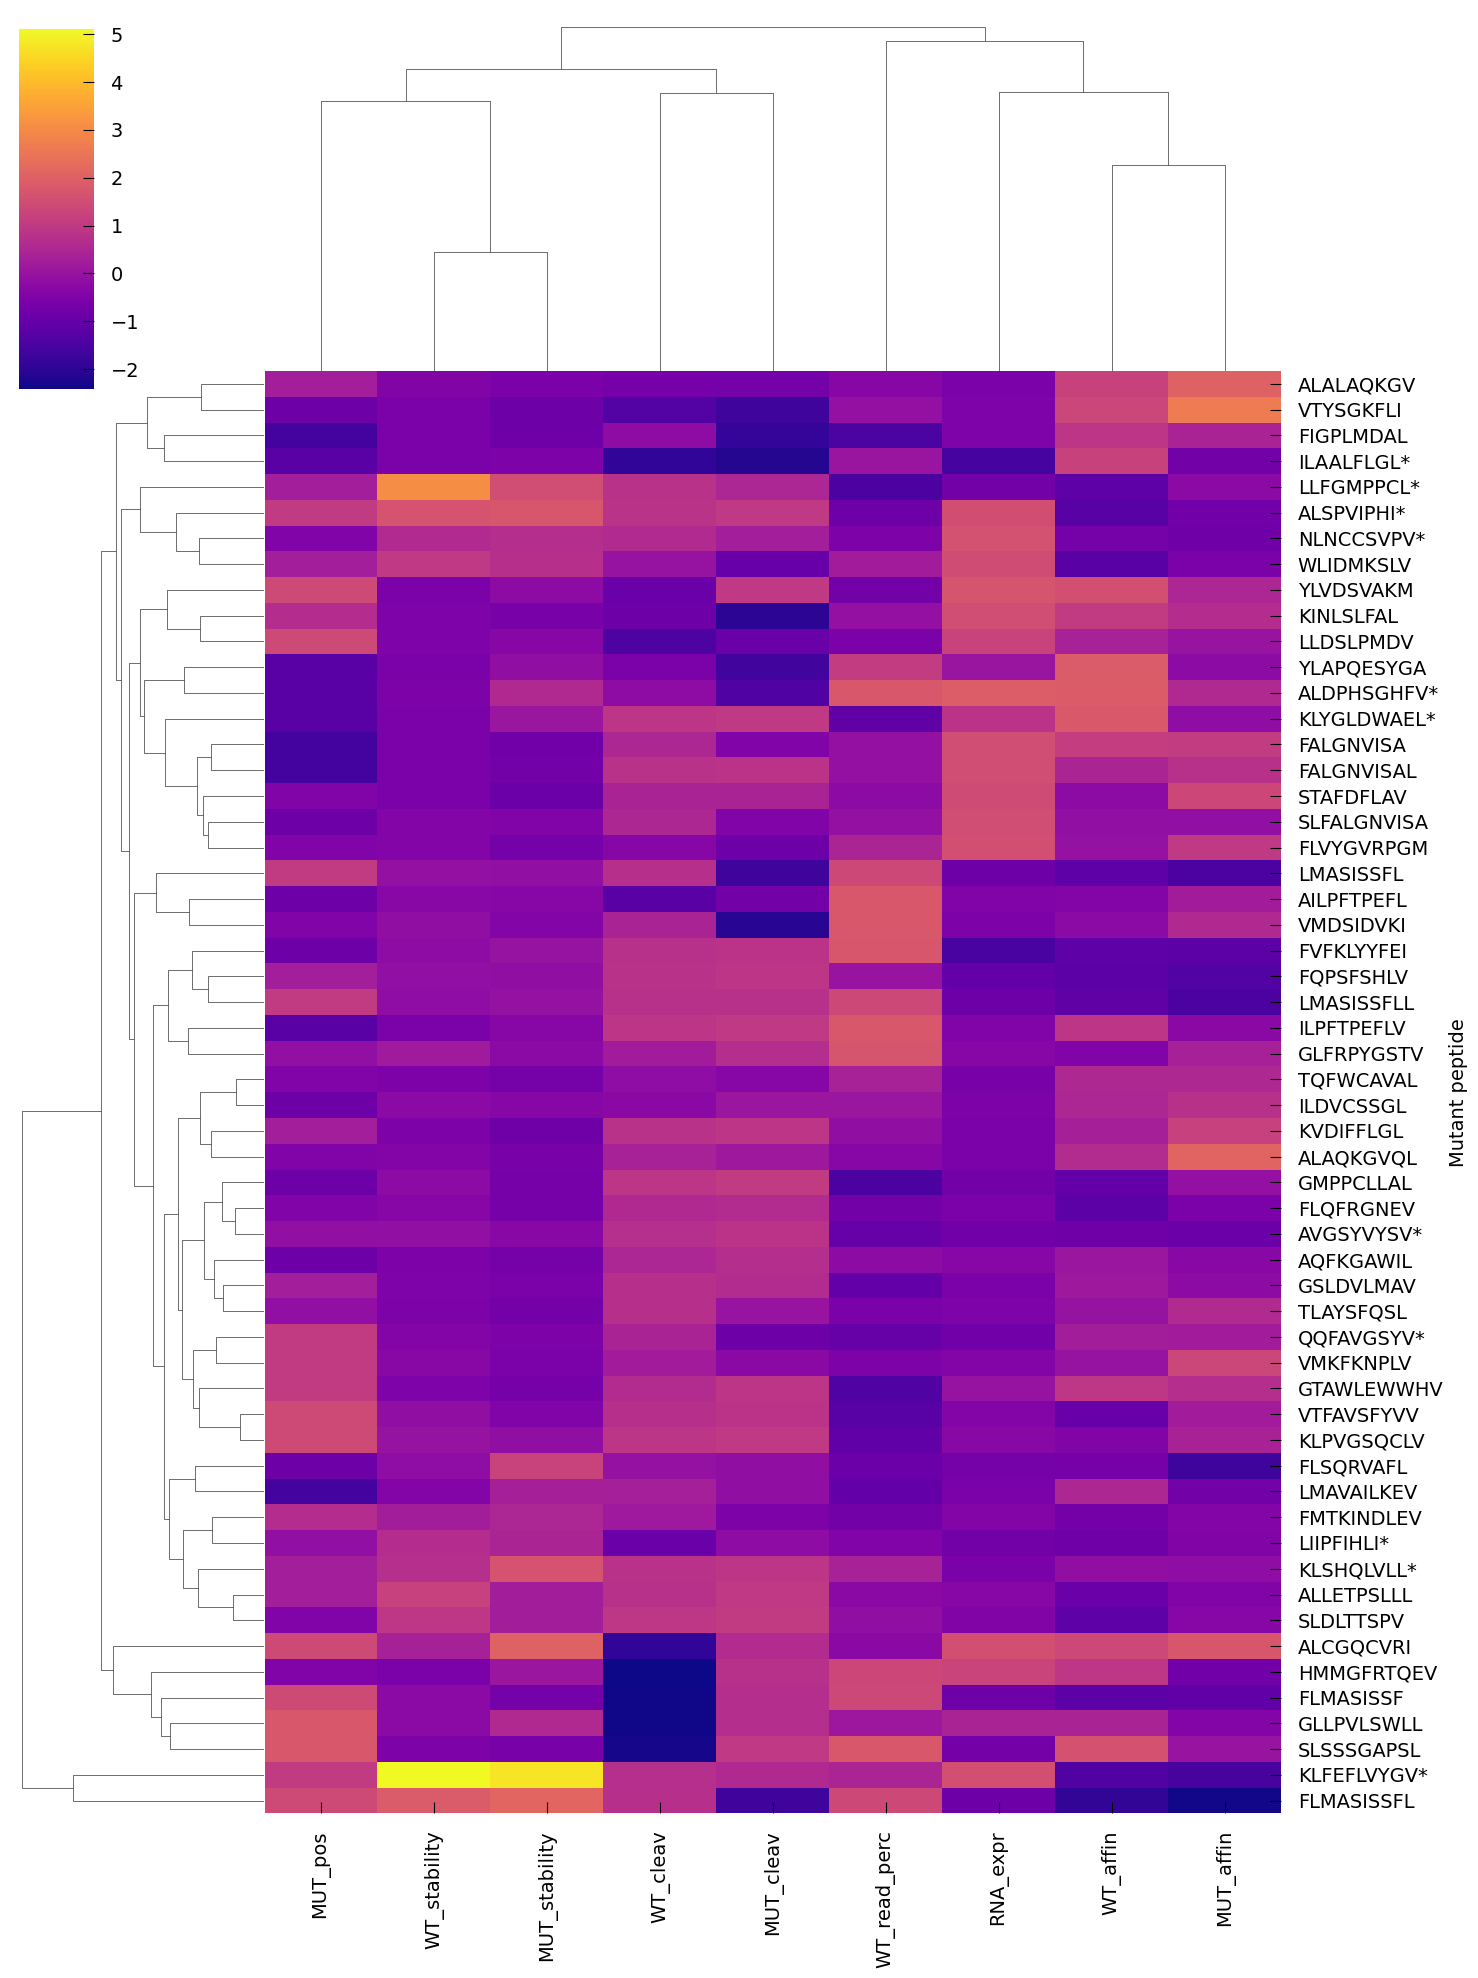

In [95]:
plt.figure(figsize=(20,30))
sns.clustermap(X_im_num[X_im['Response']!="na"],z_score=1,figsize=(15,20),cmap='plasma')
plt.show()

Next we would like perform hierachical clustering using the sklearn [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class. We  will test an array of  numbers of clusters in order to choose the optimal number of clusters. 


In [96]:
from sklearn.metrics import davies_bouldin_score

hclust = cluster.AgglomerativeClustering(n_clusters=100, linkage='ward')
hclust.fit(x_pca)

cl_cnt = hclust.n_clusters_


Counter({0: 949, 1: 85})


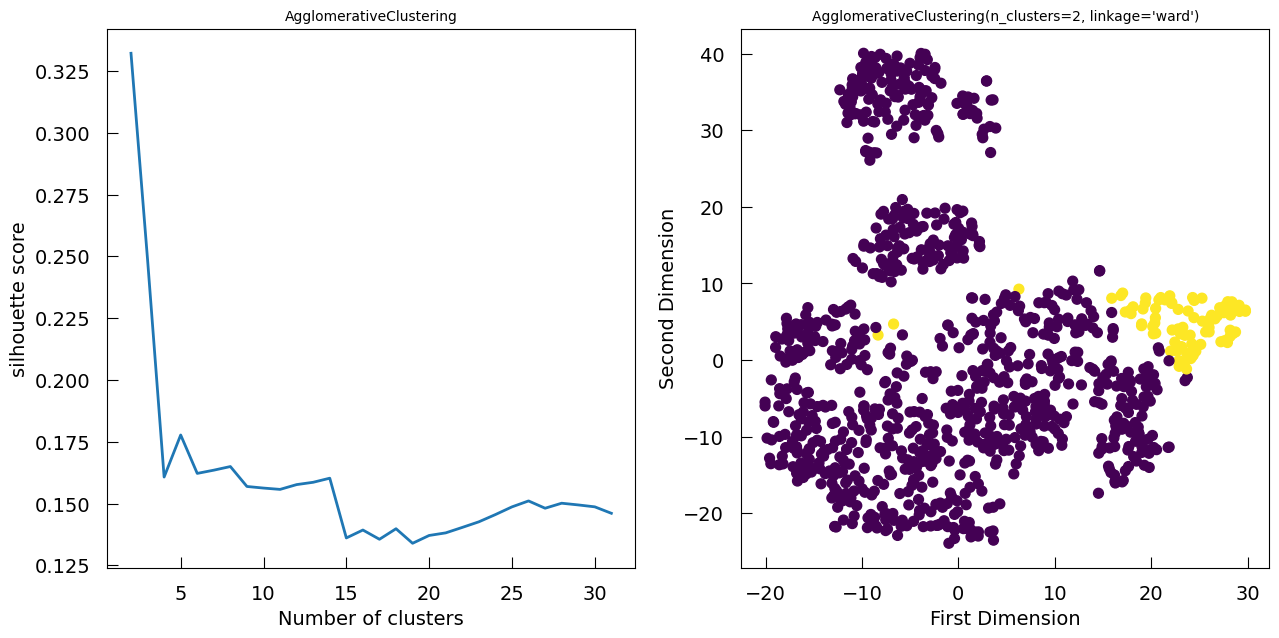

In [97]:
from sklearn.metrics import davies_bouldin_score
from collections import Counter


## we go from 2 to 32 clusters 
nr_clusters = np.arange(2,32)

scores = []
labels = []

for n in nr_clusters:
    hclust = cluster.AgglomerativeClustering(n_clusters=n, linkage='ward')
    hclust.fit(x_pca)
    
    scores.append(silhouette_score(x_pca,hclust.labels_) )
    labels.append(hclust.labels_)

    
best_idx = np.argmax( scores )
best_labels = labels[best_idx]
best_score = scores[best_idx]
best_nr_clusters = nr_clusters[best_idx]

## report and plot

print(Counter(best_labels))
plt.subplots(figsize=(15,7))


plt.subplot(1,2,1)
plt.plot(nr_clusters, scores, ls="-", lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.title('AgglomerativeClustering',fontsize=10)


plt.subplot(1,2,2)
plt.scatter(X_im_embedded[:,0],X_im_embedded[:,1],c=best_labels,s=50,cmap='viridis')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('AgglomerativeClustering(n_clusters={0}, linkage=\'ward\')'.format(best_nr_clusters),fontsize=10)

plt.show()

Now we use the scipy [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) function to plot the corresponding dendrogram.

In [98]:
#Just some code to plot the dendrogram that will be explained below
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [100]:
X_im[X_im['Response']!="na"].Response.unique()

array(['ne', 'po'], dtype=object)

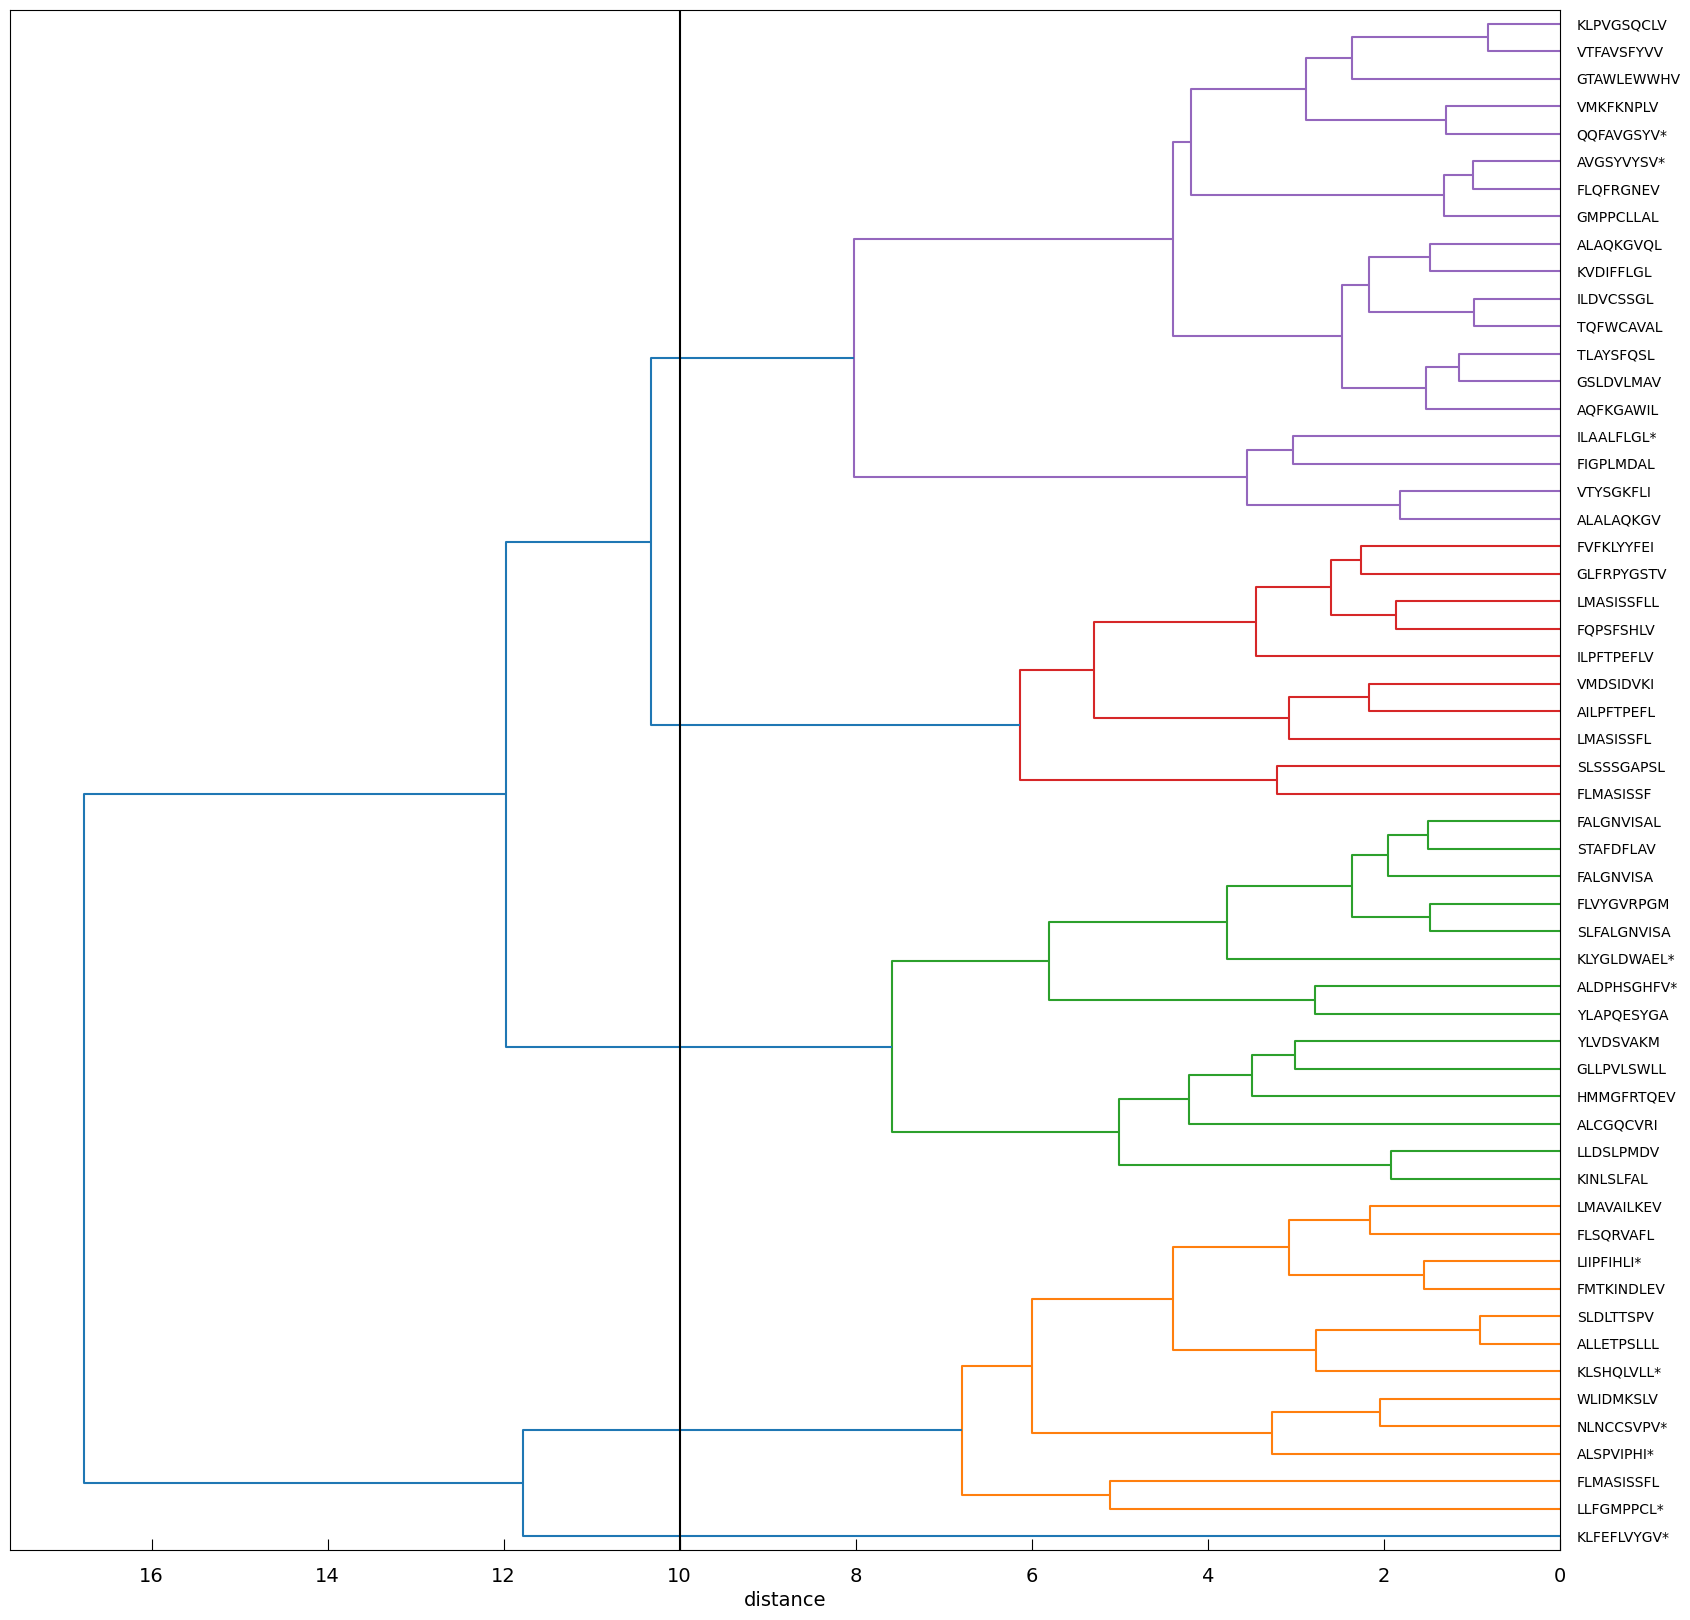

In [114]:
from sklearn import cluster
pylab.rcParams['figure.figsize'] = 20, 20
dendro = cluster.AgglomerativeClustering(
        n_clusters=None,distance_threshold=0, linkage='ward')
#here n_cluster = none because I want to explore the link
#between threshold choice and number of clusters
dendro.fit(x_pca[X_im['Response']!="na"])
plot_dendrogram(dendro,
                color_threshold=10,
                labels=X_im[X_im['Response']!="na"].index, 
                orientation='left',leaf_font_size=10)
plt.xlabel("distance")
plt.axvline(10, color='black')

plt.show()

The dendogram is the representation of the effect of your-cut off to define a cluster. For example if you decide that your threshold is going to be 15 : then you only have two clusters. If you change it to 11 you will have 4 clusters. If you put it to 0 : each point is a cluster!

AgglomerativeClustering proposes a number of options regarding how to compute the similarity between clusters: the `linkage` option:

* `ward` minimizes the variance of the clusters being merged.
* `average` uses the average of the distances of each observation of the two sets.
* `complete` or maximum linkage uses the maximum distance between all observations of the two sets.
* `single` uses the minimum of the distances between all observations of the two sets.

Take a moment to think on the implication these choice of linkage could have when clustering.

You can do so by imagining what would happen on simple sets of random data points:

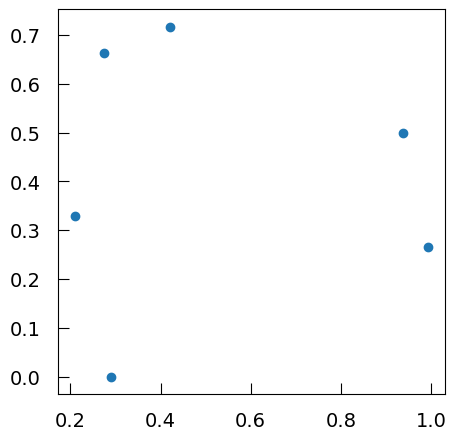

In [148]:
fig= plt.figure( figsize=(5, 5))
plt.scatter(np.random.random(6),np.random.random(6))

You can read more about these and their difference in [sklearn User's Guide](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

## DBSCAN <a class="anchor" id="DBSCAN-bullet"></a>

DBSCAN - **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise [Ester et al., Proc KDD, 1996](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220) finds core points of high density and expands clusters from them. It works well for data which contains **clusters of similar density**. 

The algorithm starts by defining core points (points that are densely packed : at least `min_samples` points within a distance `eps` from each other). Then it expands a seed cluster $C_k$ by adding a point $p_j$ to the cluster if there a point $p_{l} \in C_k$ with $dist(p_j-p_{l})<\epsilon$. Points that cannot be linked to a seed cluster are marked as outliers.

![db](../images/db.png)


DBSCAN The average run time complexity of DBSCAN is $O(nlogn)$ (worst case $O(n^2)$), which makes attractive for large datasets.

First, we need to have an idea in which range $\epsilon$ will be:

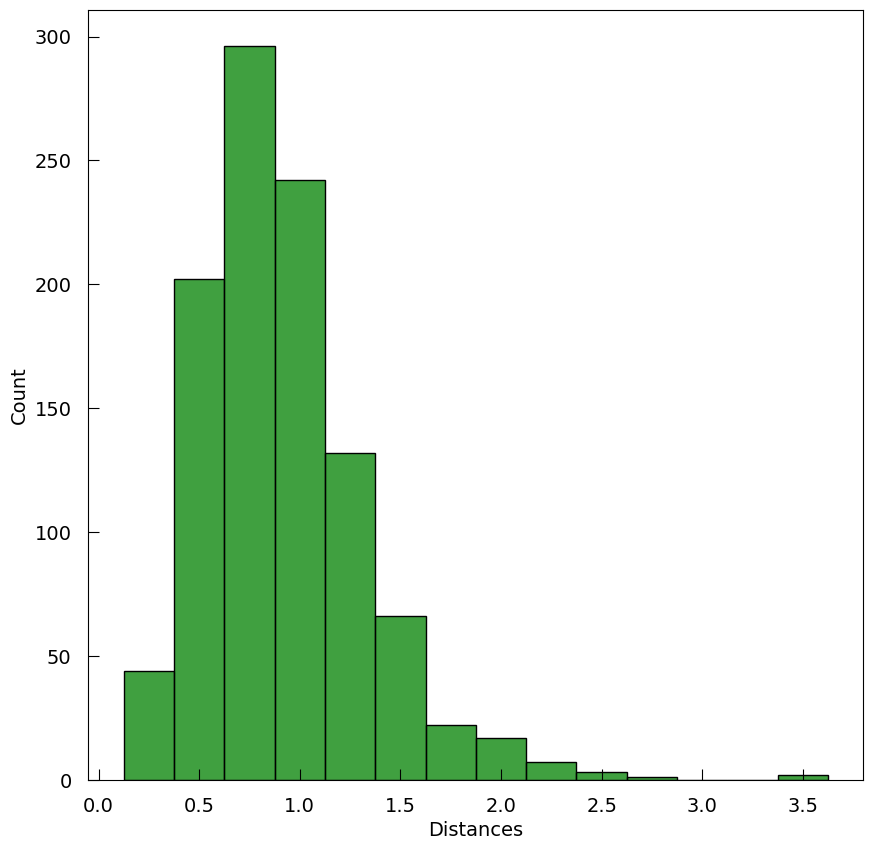

In [149]:
from sklearn.metrics import pairwise_distances

D = pd.DataFrame(pairwise_distances(x_pca, metric='euclidean'))
dists = D[D>0].min(axis=1) # get nearest neighbor distances

plt.figure(figsize=(10,10))
sns.histplot(dists, color="g", binwidth=0.25)
plt.xlabel("Distances")
plt.show()

So it looks like our epsilon would be somewhere between 0.25 and 2.

We will make our minimum number of samples vary from 5 to 25

In [150]:
%%time
from sklearn import cluster

eps = np.arange(0.20, 3, 0.10)
min_samples = np.arange(5,25,1)

## keep the scores in a 2D matrix, for each combination of eps and min_sample
scores = np.zeros( (len(eps) , len(min_samples)) )
N_assigned = np.zeros( (len(eps) , len(min_samples)) )

for i, e in enumerate( eps ):
    best_eps_score = -1
    for j, minS in enumerate( min_samples ):
        dbscan = cluster.DBSCAN(eps=e, min_samples=minS)
        dbscan.fit(x_pca)
        
        ## DBSCAN will detect some "outliers", which have a label of -1. We exclude them from the matric computation
        idx = dbscan.labels_ >= 0
        nr_clusters = len(np.unique(dbscan.labels_[idx]))
        
        N_assigned[i,j] = idx.sum()
        scores[i,j] = silhouette_score(x_pca[idx],dbscan.labels_[idx]) if nr_clusters > 1 else -1

CPU times: user 17.6 s, sys: 29.1 s, total: 46.6 s
Wall time: 12.1 s


In [151]:
#now we grab the combination with the highest value
best_idx = np.unravel_index(scores.argmax(), scores.shape)
best_eps = eps[best_idx[0]]
best_min_samples = min_samples[best_idx[1]]

# and we perform the clustering with the best values:
dbscan = cluster.DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = dbscan.fit_predict(x_pca)


Text(0.5, 1.0, 'DBSCAN(eps=0.80, min_samples=7)')

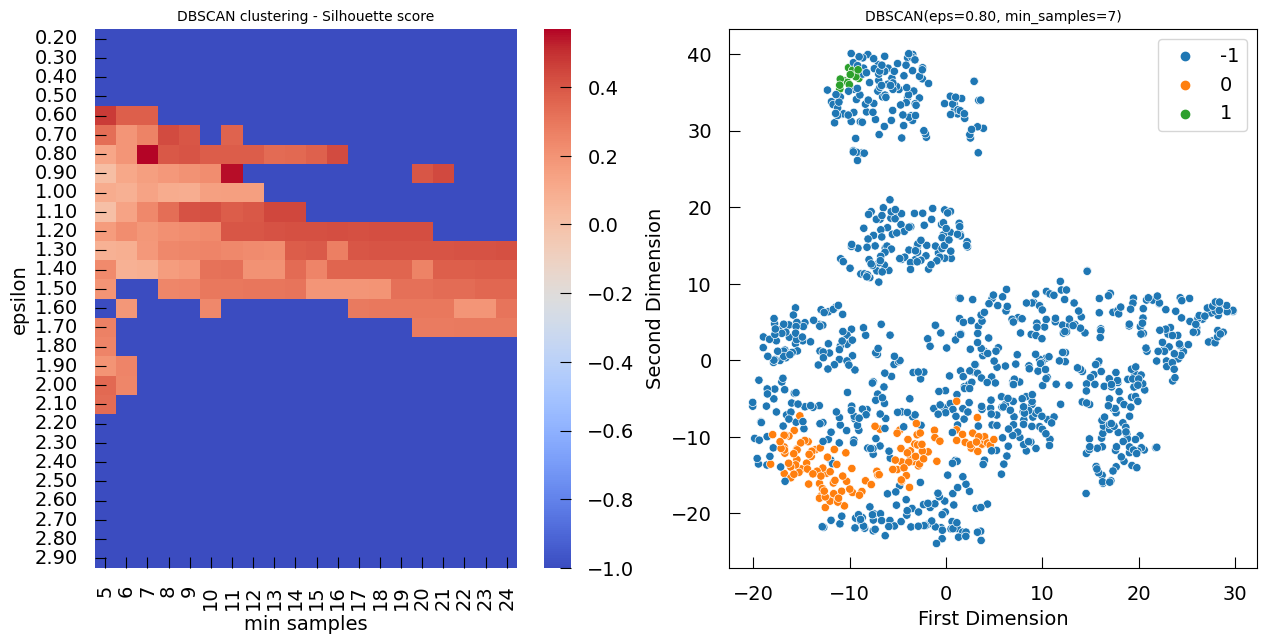

In [152]:
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.heatmap(scores,
            xticklabels=min_samples, 
            yticklabels=["{:.2f}".format(e) for e in eps],
            cmap='coolwarm' , ax = axes[0])
axes[0].set_ylabel('epsilon')
axes[0].set_xlabel('min samples')
axes[0].set_title('DBSCAN clustering - Silhouette score',fontsize=10)


sns.scatterplot(x=X_im_embedded[:,0],y=X_im_embedded[:,1],hue=best_labels.astype(str), ax=axes[1])
axes[1].set_xlabel('First Dimension')
axes[1].set_ylabel('Second Dimension')
axes[1].set_title('DBSCAN(eps={0:.2f}, min_samples={1})'.format(best_eps,best_min_samples),fontsize=10)

As you can see the solution with the highest silhouette score leaves a lot of points unclassified. 

This is something one has to be careful about with methods such as DBSCAN which have the option of leaving some points out, and can potentially be used to determine that this algorithm is not the most adapted to the nature of the data.

You can for example look at the number of points assigned to a cluster:

Text(0.5, 1.0, 'DBSCAN - number of points assigned to a cluster')

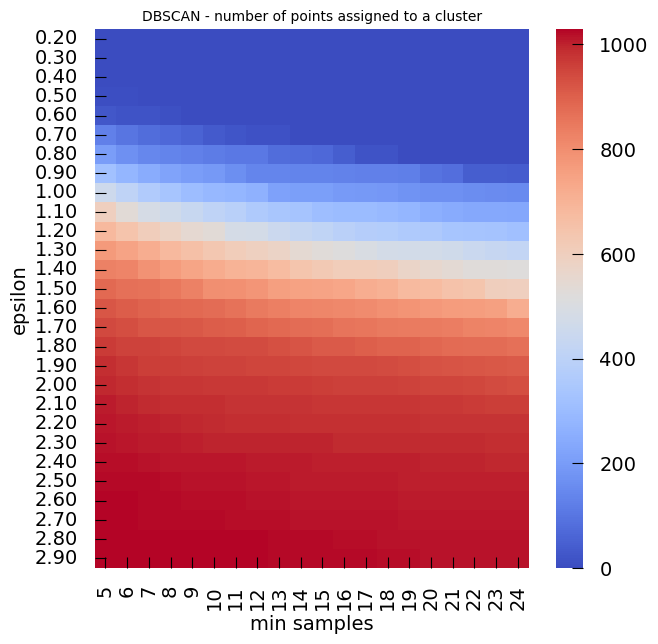

In [153]:
fig, axes = plt.subplots(1,1,figsize=(7,7))
sns.heatmap(N_assigned,
            xticklabels=min_samples, 
            yticklabels=["{:.2f}".format(e) for e in eps],
            cmap='coolwarm' , ax=axes )
axes.set_xlabel('min samples')
axes.set_ylabel('epsilon')
axes.set_title('DBSCAN - number of points assigned to a cluster'.format(best_eps,best_min_samples),fontsize=10)


**Question:** what other aspects could we look at to evaluate a clustering created by DBSCAN?

[Back to the ToC](#toc)


## Exercise: EDA and Clustering <a id="exo-kmeans"></a>

[Allison&Cicchetti 1976](https://science.sciencemag.org/content/194/4266/732)


* species: Species of animal
* bw : Body weight (kg)
* brw : Brain weight (g)
* sws : Slow wave ("nondreaming") sleep (hrs/day)
* ps : Paradoxical ("dreaming") sleep (hrs/day)
* ts : Total sleep (hrs/day) (sum of slow wave and paradoxical sleep)
* mls : Maximum life span (years)
* gt : Gestation time (days)
* pi : Predation index (1-5), 1 = least likely to be preyed upon
* sei : Sleep exposure index (1-5), 1 = least exposed (e.g. animal sleeps in a well-protected den), 5 = most exposed
* odi : Overall danger index (1-5) based on the above two indices and other information, 1 = least danger (from other animals), 5 = most danger (from other animals)

In [ ]:
df_mam = pd.read_csv('../data/mammalsleep.csv',sep=',', header=0 , index_col=0)

## some of these column make more sense as ratio
##df_mam["brain_ratio"] = df_mam.brw / df_mam.bw
##df_mam["ps_ratio"] = df_mam.ps / df_mam.ts

## dropping the now redundant columns
## df_mam.drop( columns = ["brw",'ps','sws'] , inplace=True )

df_mam.head()

 1. handle the NAs. A mean imputation should work here (ie. replace NAs by their column average)
 2. perform a PCA. Plot the PCA projected data as well as the weight of each column on the axes. What can you say ?
 3. use t-SNE to get an embedding of the data in 2D and represent it.
     **bonus :** plot the species names in the embedded space with `plt.text`
 4. perform a Kmean, or hierarchical clustering, or DBSCAN clustering on the PCA projected data. What is the best number of cluster according to the silhouette score?
 5. plot the t-SNE projected data colored according to the cluster they belong to.
 
 
**bonus**
 * try other clustering methods (eg, DBscan if you have done it with Kmeans before)
 * some variables could make more sense as a ratio, such as the brain weight / total body weight for instance. try to add some of these to the dataframe (or remove a couple of columns) and see how the results are affected.

Uncomment and execute to see the solution for each part of the exercise:

In [ ]:
# %load -r 1-5 solutions/solution_01_kmean.py

In [ ]:
# %load -r 7-42 solutions/solution_01_kmean.py

In [ ]:
# %load -r 44-60 solutions/solution_01_kmean.py

In [ ]:
# %load -r 62-81 solutions/solution_01_kmean.py

In [ ]:
# %load -r 83- solutions/solution_01_kmean.py

[Back to ToC](#toc)

## What is the best method for clustering ? <a id='best'></a>

As you surely suspect by now, there is no perfect method. 
Each algorithm makes different assumptions about the structure of your data and will thus behave well or bad depending on howyour data is actually structured.

Let's demonstrate by displaying how different algorithm perform on different dataset (example taken from the [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)):

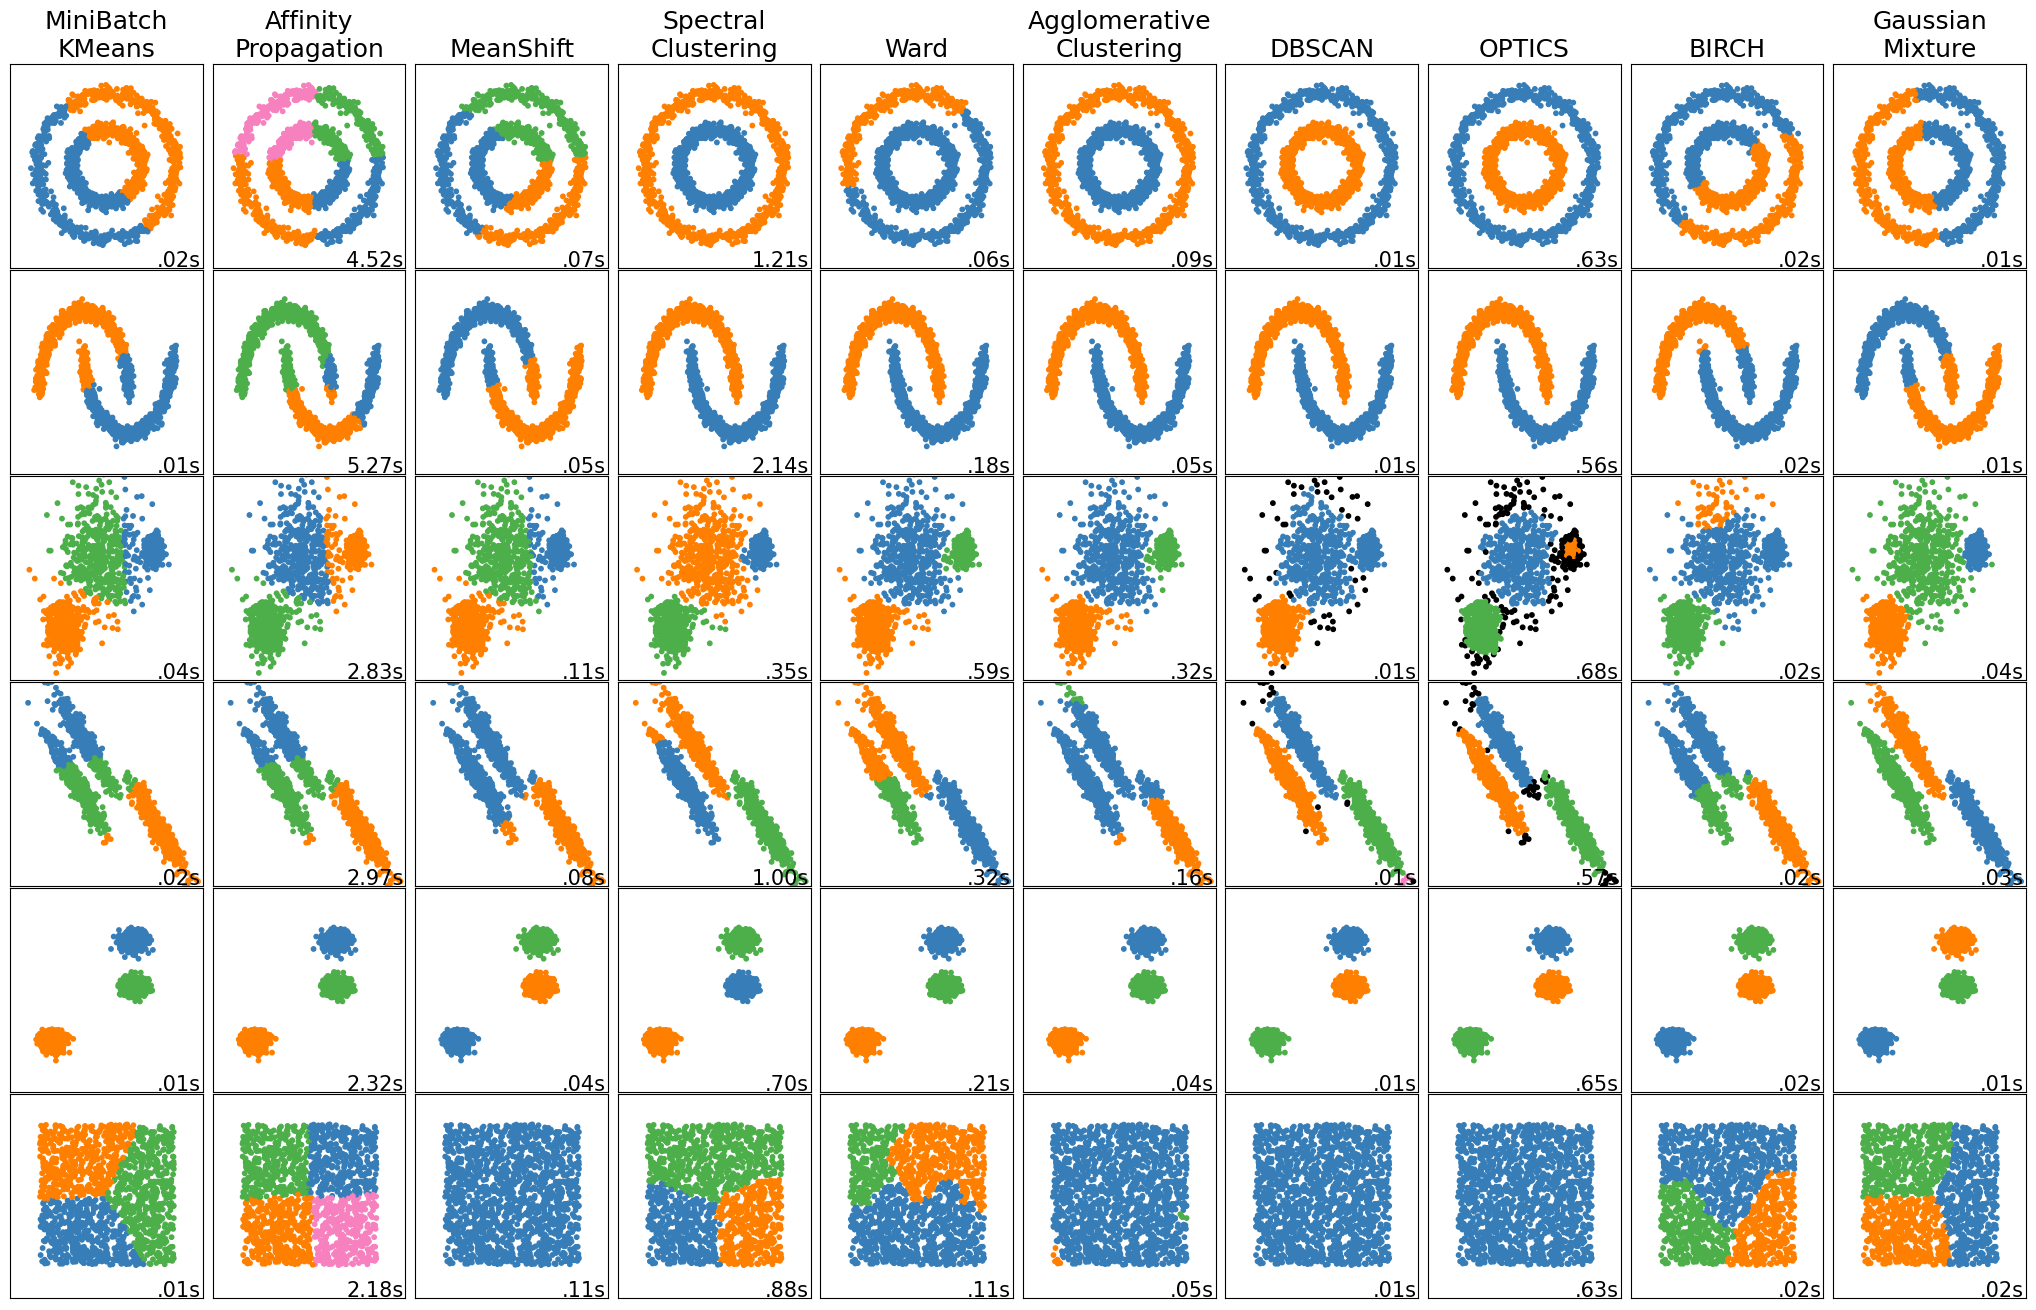

In [78]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'] , random_state=None)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Appendix <a class="anchor" id="appendix-bullet"></a>

## Gaussian mixtures <a class="anchor" id="gm-bullet"></a>

In Gaussian mixture modeling [Fraley & Raftery, The Computer Journal, 1998](https://academic.oup.com/comjnl/article-abstract/41/8/578/360856) we represent the data $\pmb{X}$ as a mixture model normal probability distributions:

$p(\pmb{x}) = \sum_{i=1}^{K}\pi_iN(\pmb{x}|\pmb{\mu_i},\pmb{\Sigma}_i)$, 

where $N(\pmb{x}|\pmb{\mu},\pmb{\Sigma})$ is a multidimensional Gaussian distribution with mean $\pmb{\mu}$ and covariance matrix $\pmb{\Sigma}$. The method uses the expectation-maximization algorithm to find the mixture components $\pmb{\pi_i}$, $\pmb{\mu_i}$ and covariance matrix $\pmb{\Sigma}_i$.

The sklearn [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) class implements the algorithm. It allows you to specify the number of clusters ('n_components'), intitial values for the parameters and constrains on the covariance matrices $\pmb{\Sigma}_i$. 

A Bayesian version [BayesianGaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture) uses priors for the mixture parameters.

In [ ]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

nr_clusters = np.arange(9)+2

aic = []
best_score = np.infty
best_nr_clusters = 0
for n in nr_clusters:
    gmm = mixture.GaussianMixture(n)
    gmm.fit(X_im_scaled)
    score = gmm.bic(X_im_scaled)
    aic.append(score)

    if score < best_score:
        best_score = score
        best_nr_clusters = n
        best_gmm = gmm
        
best_labels = best_gmm.predict(X_im_scaled)

bgmm = mixture.BayesianGaussianMixture(n_components=10,
                                       covariance_type='full',
                                       weight_concentration_prior=0.01, max_iter=500)
bgmm.fit(X_im_scaled)
best_labels_bayes = bgmm.predict(X_im_scaled)
print(np.sort(bgmm.weights_))

plt.subplots(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(nr_clusters, aic, ls="-", lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('AIC  score')
plt.title('GaussianMixture',fontsize=10)

plt.subplot(1,3,2)
plt.scatter(X_im_embedded[:,0],X_im_embedded[:,1],c=best_labels,s=50,cmap='plasma')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('GaussianMixture(n_components={0})'.format(best_nr_clusters),fontsize=10)

plt.subplot(1,3,3)
plt.scatter(X_im_embedded[:,0],X_im_embedded[:,1],c=best_labels_bayes,s=50,cmap='plasma')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('BayesianGaussianMixture(n_components={0})'.format(10),fontsize=10)

plt.show()

# Additionnal exercise : Single cell dataset <a class="anchor" id="exo-bullet"></a>

In this exercice we will be playing with a single cell RNAseq dataset from [Li et al. 2017](https://www.nature.com/articles/ng.3818#Sec28).

In their article they evaluate several advanced clustering techniques specifically developped for RNAseq data.

In this exercise, we will be using the techniques we saw in this chapter, and also exploring the effect of normalization.

> Warning: this dataset is large, and present a no so easy clustering problem. Do not hesitate to take your time and test some of your code on a smaller subset of the data.


Let's start by reading the Count matrix


In [197]:
df = pd.read_csv('../data/GSE81861_Cell_Line_COUNT.csv', index_col=0)
df = df.loc[ df.sum(axis=1) != 0 , :] # we remove transcripts whose count is 0 in all cell
df.head()

,RHA015__A549__turquoise,RHA016__A549__turquoise,RHA017__A549__turquoise,RHA018__A549__turquoise,RHA028__A549__turquoise,RHA029__A549__turquoise,RHA030__A549__turquoise,RHA031__A549__turquoise,RHA032__A549__turquoise,RHA033__A549__turquoise,...,RHC2497__H1_B2__brown,RHC2498__H1_B2__brown,RHC2499__H1_B2__brown,RHC2500__H1_B2__brown,RHC2501__H1_B2__brown,RHC2502__H1_B2__brown,RHC2503__H1_B2__brown,RHC2504__H1_B2__brown,RHC2505__H1_B2__brown,RHC2506__H1_B2__brown
chrX:99883666-99894988_TSPAN6_ENSG00000000003.10,593.0,1049.000000,542.0,375.000,186.0,81.0,579.0,0.0,50.0,0.00000,...,823.0,881.0,824.0,324.0,1271.0,119.0,655.0000,355.0,422.0,770.0
chrX:99839798-99854882_TNMD_ENSG00000000005.5,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
chr20:49505584-49575092_DPM1_ENSG00000000419.8,33.0,209.000000,0.0,325.001,173.0,42.0,5.0,1.0,161.0,1.00001,...,56.0,449.0,147.0,32.0,29.0,491.0,146.0000,139.0,105.0,29.0
chr1:169631244-169863408_SCYL3_ENSG00000000457.9,0.0,190.001000,7.0,0.000,47.0,81.0,0.0,0.0,0.0,0.00000,...,12.0,46.0,31.0,4.0,4.0,80.0,95.9983,33.0,132.0,210.0
chr1:169631244-169863408_C1orf112_ENSG00000000460.12,0.0,0.999295,0.0,0.000,43.0,553.0,1.0,0.0,0.0,0.00000,...,117.0,415.0,286.0,3.0,35.0,709.0,10.0010,1.0,212.0,1037.0


In this matrix:
 - rows are transcripts
 - columns are cell
 - values correspond to the number of reads that were assigned to a given transcript in a given cell
 
Here, you can see that our samples (cells) are in columns, and our variables (transcripts) are in rows, which is the convention for RNAseq data, but not for `sklearn` machine learning routines, so you need to transpose this data:
 

In [198]:
X = df.transpose()

### tasks

We recommend you read all tasks and notes before starting to tackle this exercise.

#### A. normalization 

We will test the impact of normalization techniques on clustering. For this, create 2 versions of the dataset:
1. log10-transform the data with a pseudo-count of 1, then use the StandardScaler to scale the data
2. use the method of the paper : computing [RPKM](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/) and filtering, following these steps:
    1. Count up the total reads in a sample and divide that number by 1,000,000 – this is our “per million” scaling factor.
    2. Divide the read counts by the “per million” scaling factor. This normalizes for sequencing depth, giving you reads per million (RPM)
    3. Divide the RPM values by the length of the gene, in kilobases, as found in the `../data/GSE81861_transcript_length.csv` file. This gives you RPKM.
    4. Keep only transcripts with a RPKM >= $10^{-3}$ in at least 2 cells
    5. log10-transform the data with a pseudo-count of $10^{-3}$
    
> NB: log-transforming X with a pseudocount of Y means: log(Y+X), this is done to avoid mathermatical errors whenthere are 0s in the data.

#### B. dimensionality reduction for visualization

3. Compute a PCA and a t-sne representation for each of the normalized dataset. Find appropriate values of the perplexity parameter for both (somewhere between 1 and 100).

#### C. hierarchical clustering 

For both normalized datasets:
4. try hierarchical clustering with "ward linkage, euclidean distance" and "average linkage, cosine distance", with  a number of clusters between 2 and 20, and measure the silhouette score each time.

> **Warning:** adapt the silhouette score to the metric distance you are currently using.

> **Warning2:** Hierarchical clustering on this data takes 2 to 5 seconds. With 2 normalizations options, 2 linkage/distance combinations, and 19 cluster numbers to evaluate, so 2*2*19=76 parameter combinations, running clustering for all parameter combinations can take around 3-6 minutes, so be sure to test your code on a smaller number of combinations firsts

5. What is the and parameter combinations (normalization technique, linkage, distance, and number of clusters) which gives the highest silhouette coefficient? 
6. Visualize the clusters given by this parameter combination on the relevant PCA and t-sne projection.

#### D. hierarchical clustering with an objective

In this experiment the cell actually belong to known cell types which are encoded in the cell names.

You can get the cell categories with the following code:
```{python}
cell_categories = pd.Series(df.columns).apply( lambda x : x.partition("_")[2].rpartition('_')[0].strip('_') )
```

They correspond to :
 - A549 : lung carcinoma
 - GM12878 : lymphoblastoid
 - H1437 : lung adenocarcinoma
 - IMR90 : fetal lung fibroblast
 - H1 : human embryonic stem cell
 - K562 : myelogenous leukemia

With some cell types presenting thecnical replicates (H1 for example).

Ideally, these cell types would correspond to clusters in the data, and the goal of the original study is to find which clustering method is able to find clusters which correspond as much as possible to the cell categories.

We will be doing something along these lines.

First, let's use what we already have:

7. compare the proposed clustering with the known categories of cells
8. looking at the silhouette score trajectories, and considering the known categories of cell, do you see sets of clustering parameters which may not have the best silhouette score but may be closer to the cell categories? check out that hypothesis.

To approach this problem in a more principled way, we will use a score which compare two clustering : the adjusted rand index, computed using the [adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) sklearn function.


Briefly, the adjusted rand index compares two clustering by considering all pairs of samples and counting cases where the two clusterings are concordant (eg, the two samples are in the same cluster in both clusterings). This number of of concordant cases is then normalized to account for chance.

You can look up the [details of adjusted_rand_score computation](https://scikit-learn.org/stable/modules/clustering.html#mathematical-formulation). Briefly, it compares two clustering by counting paris of samples where the clusterings are concordant (eg, they both assign the two samples to the same cluster) and then adjust this score to account for chance.

This score should be maximized, with 1.0 being the optimal adjusted rand index.


9. Compute the adjusted random index to choose the normalization method and clustering parameters which resemble the cell categories the best
10. Represent the best clustering according to the adjusted rand index
11. What do yo think about this shift in perspective?

> If you have read this until the end before performing all the computations, then you can see that during step 4 you could also record the adjusted rand index alongside the silhouette score, so that you don't have to perform the long computations again for question 9